In [330]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

In [356]:
import requests
import io

In [357]:
url = "https://ai4impact.org/P003/historical/energy-ile-de-france.csv"

In [367]:
r = requests.get(url)
data = r.content.decode('utf8')
ac_df = pd.read_csv(io.StringIO(data), header = None, names=['datetime','wind'])

In [331]:
df = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [332]:
df = df.drop_duplicates(subset=['datetime'])

In [333]:
df['datetime'] = df['datetime'].apply(lambda x: x.split("+")[0])

In [334]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [335]:
df = df[df.Consumption.notnull()]

In [369]:
ac_df['datetime'] = pd.to_datetime(ac_df['datetime'])

In [338]:
df.columns

Index(['Perimeter', 'Nature', 'Dated', 'Hours', 'Consumption', 'Forecast D-1',
       'Forecast J', 'Fuel oil', 'Coal', 'Gas', 'Nuclear', 'Wind', 'Solar',
       'Hydraulic', 'Pumping', 'Bioenergies', 'Ech. physical', 'Co2 rate',
       'Ech. comm. England', 'Ech. comm. Spain', 'Ech. comm. Italy',
       'Ech. comm. Swiss', 'Ech. comm. Germany-Belgium', 'Fuel oil - TAC',
       'Fuel oil - Cogen.', 'Fuel oil - Others', 'Gas - TAC', 'Gas - Cogen.',
       'Gas - CCG', 'Gas - Others', 'Hydraulic - Stream of water + lock',
       'Hydraulics - Lakes', 'Hydraulics - STEP turbines',
       'Bioenergies - Waste', 'Bioenergies - Biomass', 'Bioenergies - Biogas',
       'datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N

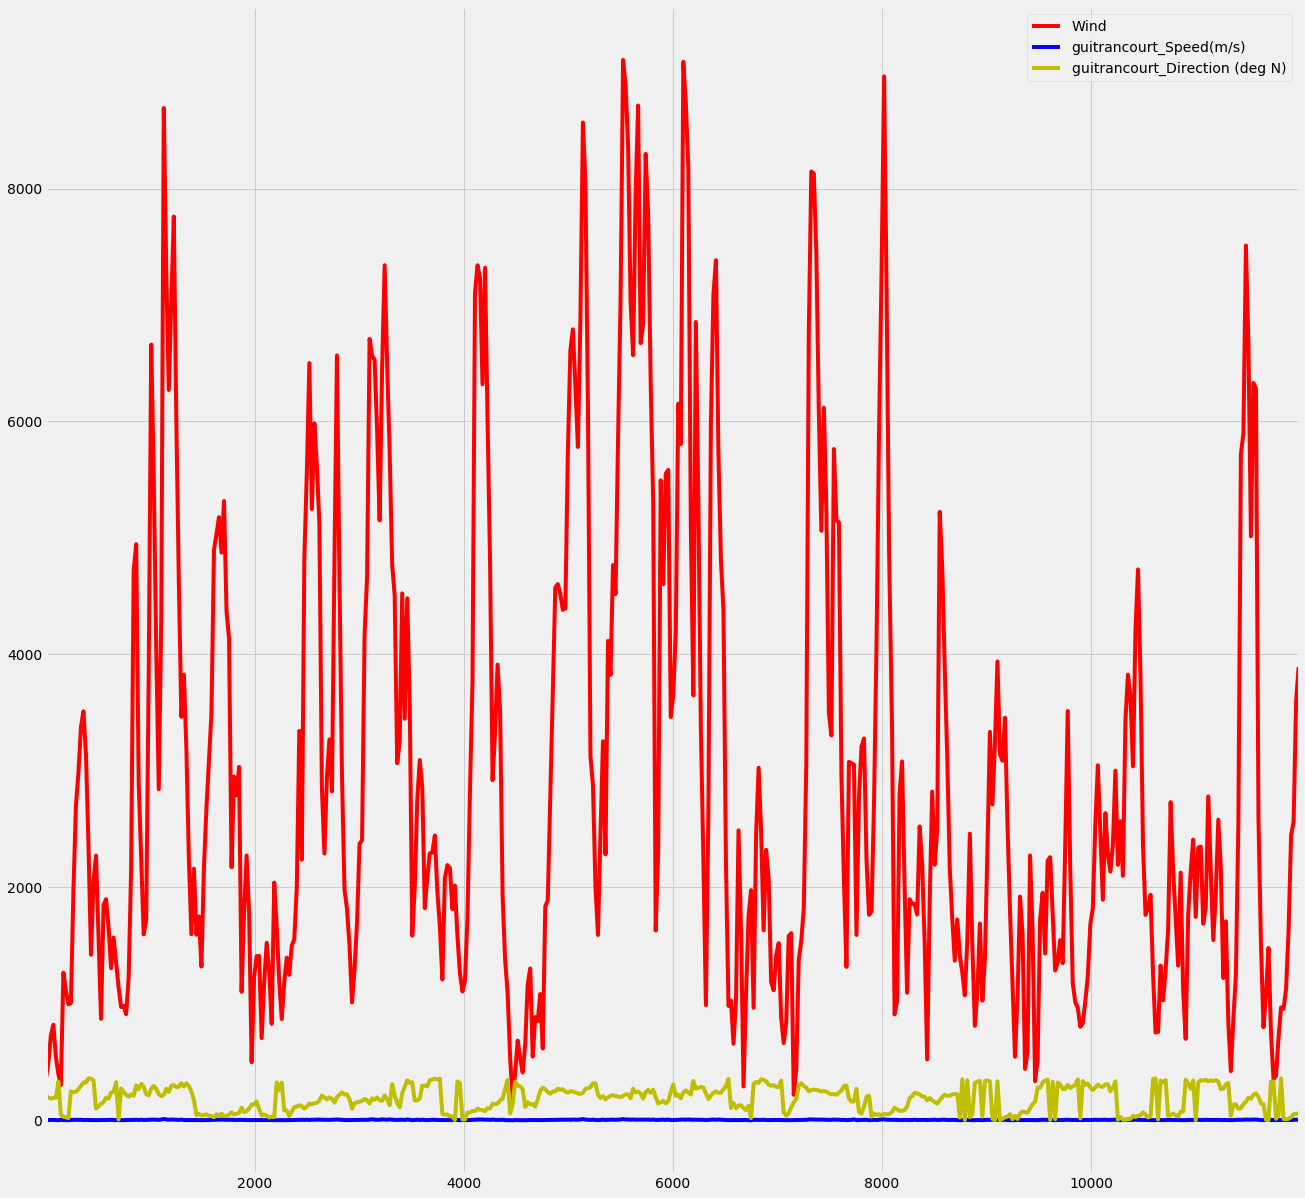

In [339]:
df[df['guitrancourt_Speed(m/s)'].notnull()].head(500)[['Wind','guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)']].astype(float).plot(style=['r','b','y'],figsize=(20,20))

In [340]:
columns_use = ['datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [341]:
agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])

In [342]:
agg_df.columns = agg_df.columns.map('_'.join)

In [343]:
agg_df = agg_df.reset_index()

In [344]:
merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')

In [371]:
check_df = merge_df.merge(ac_df, how='left', on='datetime')[['datetime','Wind_sum','wind']]

In [374]:
check_df.columns = ['datetime','wind_from_RTE','wind_from_ai4impact']

In [378]:
check_df[check_df.wind_from_ai4impact.notnull()].tail(20)

,datetime,wind_from_RTE,wind_from_ai4impact
30995,2020-07-15 13:00:00,8026.0,10250.0
30996,2020-07-15 14:00:00,8922.0,12250.0
30997,2020-07-15 15:00:00,9210.0,16750.0
30998,2020-07-15 16:00:00,9372.0,14250.0
30999,2020-07-15 17:00:00,9623.0,15500.0
31000,2020-07-15 18:00:00,9226.0,12250.0
31001,2020-07-15 19:00:00,9212.0,13250.0
31002,2020-07-15 20:00:00,7950.0,12750.0
31003,2020-07-15 21:00:00,7128.0,14250.0
31004,2020-07-15 22:00:00,7059.0,10750.0


In [242]:
merge_df = merge_df.fillna(method='ffill')

In [283]:
data = merge_df.copy()

In [284]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [285]:
#data['PJM_Load_MW_mean_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['Wind_sum_mean_daily'] = data['Wind_sum'].rolling(24).mean()
data['Wind_sum_mean_weekly'] = data['Wind_sum'].rolling(24*7).mean()
data['Wind_sum_mean_monthly'] = data['Wind_sum'].rolling(24*30).mean()

In [286]:
data['Wind_sum_std_daily'] = data['Wind_sum'].rolling(24).std()
data['Wind_sum_std_weekly'] = data['Wind_sum'].rolling(24*7).std()
data['Wind_sum_std_monthly'] = data['Wind_sum'].rolling(24*30).std()

In [287]:
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek
data['quarter'] = data['datetime'].dt.quarter
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year 
data['dayofyear'] = data['datetime'].dt.dayofyear
data['dayofmonth'] = data['datetime'].dt.day
data['weekofyear'] = data['datetime'].dt.weekofyear

In [288]:
data['target'] = data['Wind_sum'].shift(-18)

In [289]:
data['Wind_std_lag'] = data['Wind_std'].shift(-18)
data['Wind_mean_lag'] = data['Wind_mean'].shift(-18)

In [290]:
data.dropna(axis=0, how='any', inplace=True)

In [291]:
mean_squared_error(y_true=data['target'],y_pred=data['Wind_sum'])

24259508.43593554

In [292]:
mean_absolute_error(y_true=data['target'],y_pred=data['Wind_sum'])

3558.5118882504457

In [293]:
mean_absolute_percentage_error(data['target'],data['Wind_sum'])

76.14923881210825

In [275]:
data = data.drop(columns=['datetime','Wind_mean','Wind_sum','Wind_std'])

In [277]:
X_train = data[data.year.isin([2017,2018])].drop(columns=['target','year','month'])
X_test = data[data.year.isin([2019])].drop(columns=['target','year','month'])
y_train = data[data.year.isin([2017,2018])][['target']]
y_test = data[data.year.isin([2019])][['target']]

In [278]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:5332.42529	validation_1-rmse:6838.32129
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3739.61597	validation_1-rmse:4815.89551
[2]	validation_0-rmse:2623.25342	validation_1-rmse:3394.34009
[3]	validation_0-rmse:1841.20239	validation_1-rmse:2397.18359
[4]	validation_0-rmse:1293.79224	validation_1-rmse:1699.72864
[5]	validation_0-rmse:909.64154	validation_1-rmse:1209.59180
[6]	validation_0-rmse:640.85266	validation_1-rmse:866.68872
[7]	validation_0-rmse:452.39560	validation_1-rmse:628.25342
[8]	validation_0-rmse:320.77539	validation_1-rmse:463.41208
[9]	validation_0-rmse:228.41397	validation_1-rmse:349.72986
[10]	validation_0-rmse:164.38217	validation_1-rmse:271.45593
[11]	validation_0-rmse:119.56213	validation_1-rmse:220.08235
[12]	validation_0-rmse:88.54371	validation_1-rmse:187.34695
[13]	validation_0-rmse:67.81659	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [279]:
pyplot.rcParams["figure.figsize"] = (20,10)

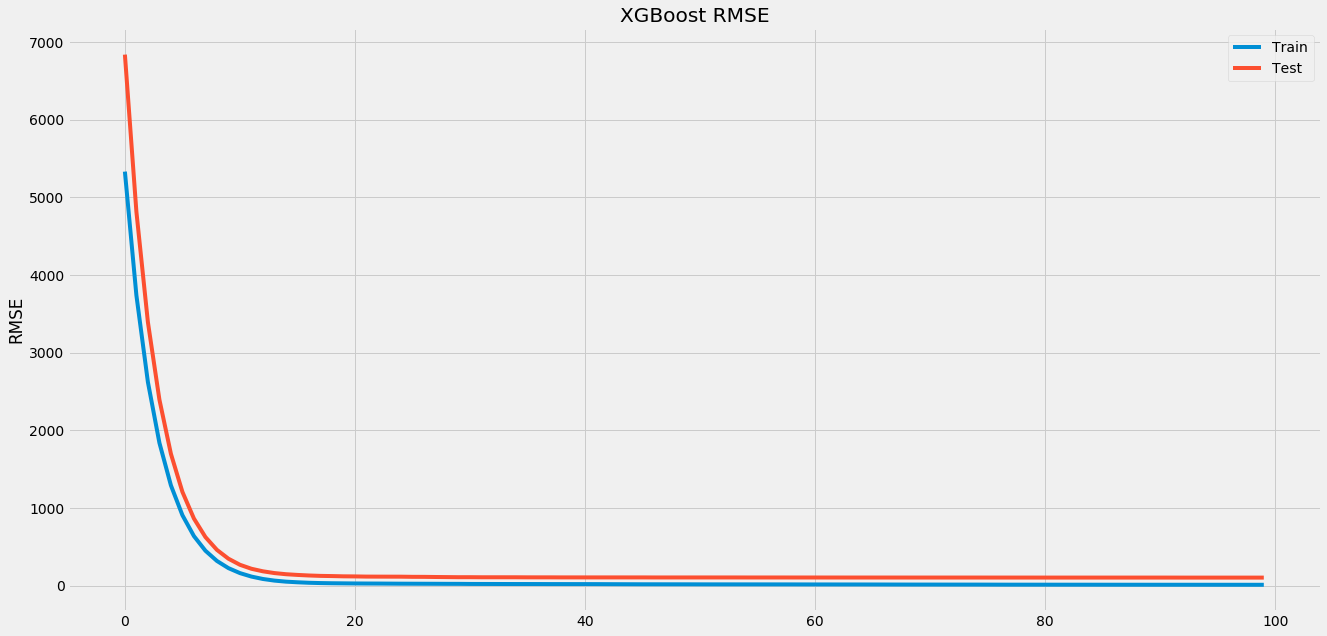

In [280]:
# retrieve performance metrics
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

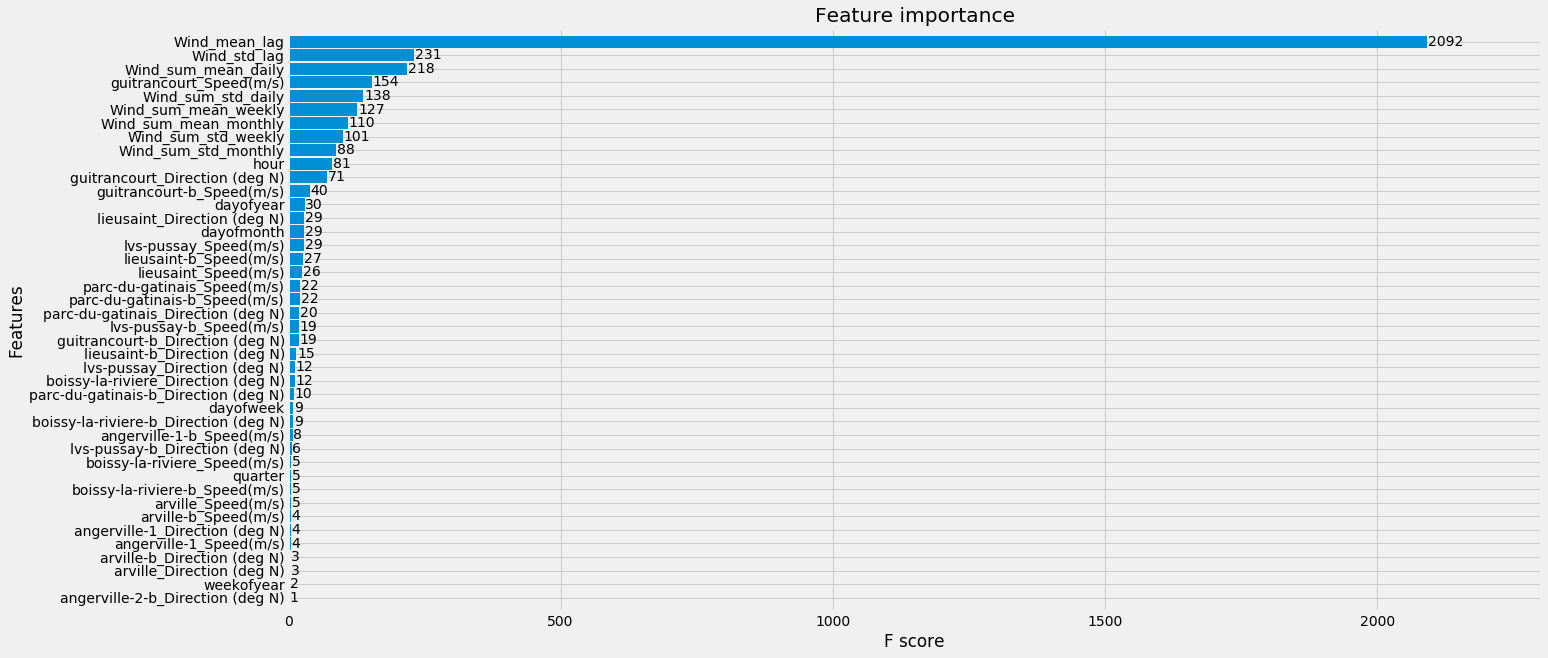

In [281]:
_ = plot_importance(reg, height=0.9)

In [295]:
mean_squared_error(y_true=y_test,y_pred=reg.predict(X_test))

11312.34822981581

In [296]:
mean_absolute_error(y_true=y_test,y_pred=reg.predict(X_test))

24.826631580857924

In [297]:
mean_absolute_percentage_error(y_test,reg.predict(X_test))

155.46781785405773

In [303]:
test_result = data[data.year.isin([2019])].copy()
test_result['prediction'] = reg.predict(X_test)

In [304]:
test_result['error'] = test_result['target'] - test_result['prediction']
test_result['abs_error'] = test_result['error'].apply(np.abs)
error_by_day = test_result.groupby(['year','month','dayofmonth']) \
    .mean()[['target','prediction','error','abs_error']]

In [312]:
test_result.sort_values('abs_error', ascending=False)

,datetime,Wind_mean,Wind_sum,Wind_std,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),lieusaint_Speed(m/s),lieusaint_Direction (deg N),lvs-pussay_Speed(m/s),lvs-pussay_Direction (deg N),...,year,dayofyear,dayofmonth,weekofyear,target,Wind_std_lag,Wind_mean_lag,prediction,error,abs_error
19640,2019-03-30 07:00:00,2490.5,4981.0,245.366053,2.09,180.0,2.63,185.0,2.87,190.0,...,2019,89,30,13,4437.0,10.404326,1109.25,2214.943848,2222.056152,2222.056152
19639,2019-03-30 06:00:00,2847.0,5694.0,9.899495,2.09,180.0,2.63,185.0,2.87,190.0,...,2019,89,30,13,4437.0,10.404326,1109.25,2214.943848,2222.056152,2222.056152
25819,2019-12-12 18:00:00,11218.0,22436.0,104.651804,7.01,168.0,7.49,168.0,6.82,171.0,...,2019,346,12,50,26647.0,6.363961,13323.50,24447.392578,2199.607422,2199.607422
21771,2019-06-27 01:00:00,5399.0,10798.0,31.112698,5.80,41.0,4.81,28.0,5.11,41.0,...,2019,178,27,26,9750.0,213.546248,4875.00,11942.224609,-2192.224609,2192.224609
19245,2019-03-13 20:00:00,10502.0,21004.0,82.024387,6.71,279.0,5.29,280.0,5.16,281.0,...,2019,72,13,11,26553.0,13.435029,13276.50,24452.962891,2100.037109,2100.037109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23078,2019-08-20 12:00:00,1418.5,2837.0,118.086832,3.71,278.0,1.97,302.0,2.49,303.0,...,2019,232,20,34,3440.0,125.865007,1720.00,3439.988770,0.011230,0.011230
21151,2019-06-01 05:00:00,988.0,1976.0,24.041631,1.20,161.0,1.29,151.0,1.08,127.0,...,2019,152,1,22,3788.0,101.823376,1894.00,3788.003906,-0.003906,0.003906
19992,2019-04-13 22:00:00,3310.5,6621.0,106.773124,3.44,29.0,3.23,29.0,3.00,39.0,...,2019,103,13,15,5279.0,101.116270,2639.50,5278.997070,0.002930,0.002930
20820,2019-05-18 10:00:00,792.5,1585.0,38.890873,2.05,57.0,3.00,166.0,2.73,164.0,...,2019,138,18,20,2061.0,45.961941,1030.50,2061.000244,-0.000244,0.000244


In [305]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(20)

target    prediction      error   abs_error
year month dayofmonth                                                   
2019 6     27           6727.416667   6819.972656 -92.555837  105.266388
     4     27          10368.125000  10424.918945 -56.793538   83.076457
     10    10          11037.916667  11090.205078 -52.288249   70.150716
     3     17           8734.833333   8781.118164 -46.284993   54.848755
           8           18365.333333  18407.914062 -42.580688   60.348104
     4     1            7782.333333   7821.664062 -39.330790   40.486715
           4            6578.041667   6612.980469 -34.938965   34.938965
           2            5404.333333   5436.698242 -32.364807   32.364807
           3            4600.166667   4629.881348 -29.714864   30.036764
     12    16          15063.625000  15092.651367 -29.026082   31.058634
     2     12           3318.541667   3342.271240 -23.729691   40.584590
           8           20699.708333  20721.716797 -22.008830   58.042114
     10    25          13253.583333  13275.421875 -21.838745   29.637004
     3     5           17984.166667  18005.972656 -21.805684   23.451436
     12    15           9129.041667   9148.927734 -19.885986   23.613200
           28           5034.666667   5053.367188 -18.700521   19.509155
     9     28          18338.291667  18356.744141 -18.453328   47.537069
     3     27           5254.000000   5272.418945 -18.418894   19.623667
     4     9            4957.875000   4975.452637 -17.577464   18.481089
     12    25           9007.041667   9024.567383 -17.526194   19.475739

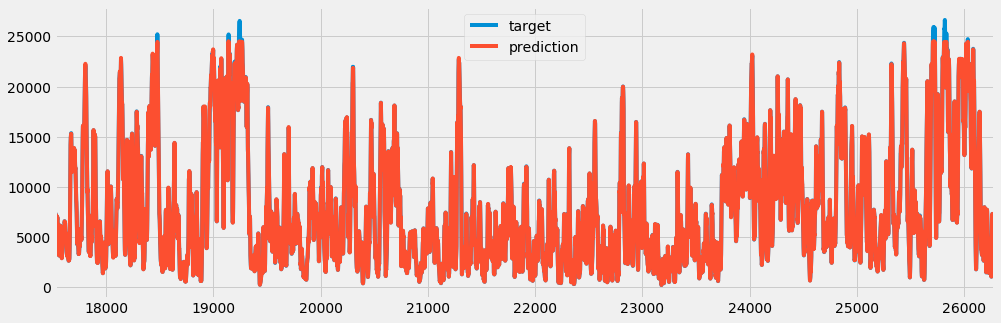

In [308]:
_ = test_result[['target','prediction']].plot(figsize=(15, 5))